In [1]:
# importing Libraries


from __future__ import absolute_import,division,print_function,unicode_literals

import tensorflow as tf, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os,json
import tensorflow_datasets as tfds
from IPython.display import clear_output

In [2]:
#changing the directory path to Downloads folder where my data exists for feeding an algorithm
os.chdir("../Downloads")

In [3]:
#Fetching the data from file and loading into variable memory
with open(os.getcwd()+"/customersdata.json","r+") as fd:
    customers_data = [json.loads(i) for i in fd.readlines()]


In [4]:
# payment_type, payment_provider, payment_issuer = set(),set(),set()
# for customer in customers_data:
#     for payment in customer["paymentMethods"]:
#         payment_type.add(payment["paymentMethodType"])
#         payment_provider.add(payment["paymentMethodProvider"])
#         payment_issuer.add(payment["paymentMethodIssuer"])

In [5]:
# payment_type,payment_provider,payment_issuer

<h1> extracting the Features from Data </h1>
<ul>
    <li>After inspecting the data Fraudulent column is used as Label predictor</li>
    <li>customer details like email, phone, device, ip details changes for every customer so, if we keep those features might not be helpful for algorithm to analyze underlying patterns so removing them </li>
    <li>There might be chances of having customer address & orders addresses are different which might be helpful to analyze underlying patterns whether fraudulent or not. So, creating new feature like "address_count" based on customers original address & orders addresses </li>
    <li>Orders Id, Amount changes for every order mightn't be helpful to analyze patterns & status field also</li>
    <li>Payments method, provider, issuers details,Id changes for every payment method mightn't be helpful to analyze patterns</li>
    <li>Payments gateways added count & payment type might be helpful to analyze patterns </li>
    <li>In Transaction Id,order Id, payment Id changes frequently for every transaction generally not necessary </li>
</ul>

In [6]:
def address_count(address,orders_data):
    count = 1
    if(len(orders_data) == 0):
        return count
    else:
        for order in orders_data:
            if(order["orderShippingAddress"] != address):
                count+=1
        return count
def payment_information(payment_details):
    payment_data = []
    payment_info = {}
    if(len(payment_details) == 0):
        payment_info["payment_type"] = "N/A"
        payment_info["payment_provider"] = "N/A"
        payment_info["payment_issuer"] = "N/A"
        payment_data.append(payment_info)
        return payment_data
    else:
        for i in payment_details:
            payment_info = {}
            payment_info["payment_type"] = i["paymentMethodType"]
            payment_info["payment_provider"] = i["paymentMethodProvider"]
            payment_info["payment_issuer"] = i["paymentMethodIssuer"]
            payment_data.append(payment_info)
        return payment_data

In [7]:
modified_customers = []
for customer in customers_data[:]:
    data = {}
    data["fraudulent"] = 1 if(customer["fraudulent"]) else 0
    data["address_count"] = address_count(customer["customer"]["customerBillingAddress"], customer["orders"])
    data["payment_gateways_count"] = len(customer["paymentMethods"])
    for i in payment_information(customer["paymentMethods"]):
        customer_dict = data.copy()
        customer_dict.update(i)
        modified_customers.append(customer_dict)

In [8]:
df = pd.DataFrame(modified_customers)
df.pop("payment_issuer") #removed this feature column to check accuracy improving or not
df.pop("payment_provider") #removed this feature column to check accuracy improving or not
df

,fraudulent,address_count,payment_gateways_count,payment_type
0,0,1,1,card
1,1,3,7,bitcoin
2,1,3,7,card
3,1,3,7,card
4,1,3,7,card
...,...,...,...,...
349,1,4,6,card
350,0,3,4,card
351,0,3,4,paypal
352,0,3,4,card


In [9]:
#Splitting the DataFrame for training & testing purpose
dftrain = df[:250]
dftest = df[250:]
dftest.head()

,fraudulent,address_count,payment_gateways_count,payment_type
250,0,2,3,card
251,0,2,3,card
252,0,2,3,card
253,1,4,1,bitcoin
254,1,3,5,card


In [10]:
# seperating the labels predictor from dataframe dataset
y_train = dftrain.pop("fraudulent")
y_test = dftest.pop("fraudulent")

In [11]:
#To Create the Tensorflow dataset object from pandas DataFrame

def make_input_fn(features, labels, shuffle = True, batch_size = 10,n_epochs=10):
    def input_fn():
        ds = tf.data.Dataset.from_tensor_slices((dict(features),labels))
        if(shuffle):
            ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size).repeat(n_epochs)
        return ds
    return input_fn

In [12]:
train_input_fn = make_input_fn(dftrain,y_train)
test_input_fn = make_input_fn(dftest,y_test,shuffle=False,n_epochs = 1)

In [13]:
ds = make_input_fn(dftrain,y_train)()
for feature_batch,label_batch in ds.take(1):
    print("feature_batch keys",feature_batch.keys())
    print("label batch is:",label_batch.numpy())

feature_batch keys dict_keys(['address_count', 'payment_gateways_count', 'payment_type'])
label batch is: [1 0 1 0 0 0 0 1 0 0]


In [14]:
#creating feature_columns

feature_columns = []
categorical_columns = ["payment_type"]
numeric_columns = ["address_count","payment_gateways_count"]

for key in categorical_columns:
    vocabulary_list = df[key].unique()
    indicator_column = tf.feature_column.categorical_column_with_vocabulary_list(key,vocabulary_list)
    feature_columns.append(tf.feature_column.indicator_column(indicator_column))
for key in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(key))

In [15]:
tf.keras.layers.DenseFeatures(feature_columns)(feature_batch)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


<tf.Tensor: id=87, shape=(10, 7), dtype=float32, numpy=
array([[ 2.,  2.,  0.,  0.,  1.,  0.,  0.],
       [ 2.,  1.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  4.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  1.,  0.,  0.],
       [ 3.,  4.,  1.,  0.,  0.,  0.,  0.],
       [ 2.,  3.,  1.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  1.,  0.,  0.,  0.,  0.],
       [ 3., 14.,  0.,  0.,  1.,  0.,  0.],
       [ 2.,  3.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  0.,  0.,  0.,  0.]], dtype=float32)>

In [16]:
linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)

linear_est.train(train_input_fn)
result = linear_est.evaluate(test_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.721154
accuracy_baseline         0.500000
auc                       0.813424
auc_precision_recall      0.842487
average_loss              0.537789
label/mean                0.500000
loss                      0.577658
precision                 0.701754
prediction/mean           0.531797
recall                    0.769231
global_step             250.000000
dtype: float64


In [17]:
#to imporove accuracy lets try with crossed feature_columns
payment_gateway_x_type = [tf.feature_column.crossed_column(["payment_gateways_count","payment_type"],hash_bucket_size = 100)]
# address_payment_count = payment_gateway_x_type.append(tf.feature_column.crossed_column(["payment_gateways_count","address_count"],hash_bucket_size = 100))

linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns+payment_gateway_x_type)
linear_est.train(train_input_fn)
result = linear_est.evaluate(test_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.740385
accuracy_baseline         0.500000
auc                       0.782914
auc_precision_recall      0.838037
average_loss              0.542021
label/mean                0.500000
loss                      0.591637
precision                 0.765957
prediction/mean           0.505234
recall                    0.692308
global_step             250.000000
dtype: float64


In [18]:
pred_dicts = list(linear_est.predict(test_input_fn))
probs = [pred["probabilities"][pred["class_ids"][0]] for pred in pred_dicts]


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\vijay\AppData\Local\Temp\tmpkfs8z5jw\model.ckpt-250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


(0, 1.05)

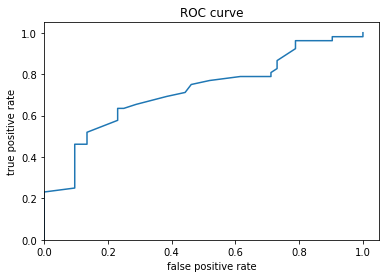

In [19]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)